## **_The Edge Up: AAPL_**

### **_Libraries_**

In [3]:
# Data engineering
import pandas_ta as ta
import yfinance as yf
import pandas as pd
import numpy as np

# Plotting
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

### **_Network Code_**

In [4]:
# A template of a layer class
class Layer:
    
    # Initialise a layer
    def __init__(self):
        self.input = None
        self.output = None

    # Forward method
    def forward(self, input):
        pass

    # Backward method
    def backward(self, output_gradient, learning_rate):
        pass

# Fully connected layer class
class Layer_Dense(Layer):

    # Initialise weights and biases
    def __init__(self, input_size, output_size, pre_weights, pre_biases, seed):

        # Setting shape 
        self.shape = (input_size, output_size)

        # Setting a seed
        np.random.seed(seed)

        # Initialising a random normal distribution of weights and biases
        self.weights = np.random.randn(output_size, input_size)
        self.biases = np.random.randn(output_size, 1)

        # Checking if the weights are overridable
        if type(pre_weights) == np.ndarray:

            # Resetting the weights
            self.weights = pre_weights

        # Checking if the biases are overridable
        if type(pre_biases) == np.ndarray:

            # Resetting the biases
            self.biases = pre_biases

    # Forward method
    def forward(self, input):

        # Calculating the weighted sum
        self.input = input
        self.output = np.dot(self.weights, self.input) + self.biases

        # Returning the output
        return self.output
    
    # Backward method
    def backward(self, output_gradient, learning_rate):

        # Calcualting the derivative of the error wrt to the weights
        weights_gradient = np.dot(output_gradient, self.input.T)

        # Updating the weights and biases
        self.weights -= learning_rate * weights_gradient
        self.biases -= learning_rate * output_gradient

        # Returning the derivative of the error wrt to the input
        return np.dot(self.weights.T, output_gradient)

# Neuron dropout layer class
class Layer_Dropout(Layer):

    # Initialize dropout layer
    def __init__(self, dropout_rate):
        self.dropout_rate = dropout_rate
        self.mask = None

    # Forward method
    def forward(self, input, training=True):
        if training:
            # Generate a mask for dropout
            self.mask = np.random.binomial(1, 1 - self.dropout_rate, size=input.shape) / (1 - self.dropout_rate)
            # Apply dropout mask
            self.output = input * self.mask
        else:
            # During inference, scale the output
            self.output = input * (1 - self.dropout_rate)
        return self.output

    # Backward method
    def backward(self, output_gradient, learning_rate):
        # Backpropagate through dropout layer
        return output_gradient * self.mask

# Activation layer class
class Activation(Layer):
    
    # Initialising attributes for the forward and backward passes
    def __init__(self, activation, activation_derivative):
        self.activation = activation
        self.activation_derivative = activation_derivative

    # Forward method
    def forward(self, input):
        self.input = input
        return self.activation(self.input)
    
    # Backward method
    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_derivative(self.input))

# Sigmoid activation layer subclass
class Sigmoid(Activation):
    def __init__(self):
        sigmoid = lambda x: (1 / (1 + np.exp(-x)))
        sigmoid_derivative = lambda x: ((np.exp(-x)) / ((1 + np.exp(-x)) ** 2))
        super().__init__(sigmoid, sigmoid_derivative)

# Hyperbolic tangent activation layer subclass
class TanH(Activation):
    def __init__(self):
        tanh = lambda x: ((np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)))
        tanh_derivative = lambda x: (4 / ((np.exp(x) + np.exp(-x))**2))
        super().__init__(tanh, tanh_derivative)

# ReLU activation layer subclass
class ReLU(Activation):
    def __init__(self):
        ReLU = lambda x: np.maximum(0, x)
        ReLU_derivative = lambda x: 1. * (x > 0)
        super().__init__(ReLU, ReLU_derivative)

# Softmax activation layer subclass
class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        n = np.size(self.output)
        tmp = np.tile(self.output, n)
        return np.dot(tmp * (np.identity(n) - np.transpose(tmp)), output_gradient)

# A template of a loss class
class Loss:

    # Nothing to initialise
    def __init__(self):
        pass

    # Forward method
    def forward(self, y_true, y_pred):
        pass

    # Backward method
    def backward(self, y_true, y_pred):
        pass

# Mean Squared Error loss subclass
class MeanSquaredError(Loss):
    
    # Forward method
    def forward(self, y_true, y_pred):
        return np.mean(np.power(y_true - y_pred, 2))
    
    # Backward method
    def backward(self, y_true, y_pred):
        return 2 * (y_pred - y_true) / np.size(y_true)

# Binary cross entropy loss subclass
class BinaryCrossEntropy(Loss):

    # Forward method
    def forward(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    # Backward method
    def backward(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return - (y_true / y_pred - (1 - y_true) / (1 - y_pred))

# Weighted binary cross entropy loss subclass
class WeightedBinaryCrossEntropy(Loss):

    # Initialising the weights
    def __init__(self, class_weights):
        self.class_weights = class_weights

    # Forward method
    def forward(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        # Compute binary cross-entropy loss
        bce_loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        # Apply class weights
        weighted_bce_loss = bce_loss * self.class_weights
        # Return mean loss
        return np.mean(weighted_bce_loss)

    # Backward method
    def backward(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        # Compute gradients of binary cross-entropy loss
        grad_loss = - ((y_true / y_pred) - ((1 - y_true) / (1 - y_pred)))
        # Apply class weights to gradients
        weighted_grad_loss = grad_loss * self.class_weights
        # Return mean gradient
        return np.mean(weighted_grad_loss)

# Categorical cross entropy loss subclass
class CatCrossEntropy(Loss):

    # Forward method
    def forward(self, y_true, y_pred):
        epsilon = 1e-9
        loss = -np.sum(y_true * np.log(y_pred + epsilon)) / y_pred.shape[0]
        return loss
    
    # Backward method
    def backward(self, y_true, y_pred):
        epsilon = 1e-9
        grad = -(y_true / (y_pred + epsilon)) / y_pred.shape[0]
        return grad

### **_Network Operators_**

In [5]:
# Predicting function
def Predict(x, network, training):
    # Forward pass of the given network
    output = x
    for layer in network:
        if isinstance(layer, Layer_Dropout):
            output = layer.forward(output, training=training)
        else:
            output = layer.forward(output)
    
    # Returning the prediction
    return output

# The training function
def Train(X, Y, network, epochs, loss, learning_rate, verbose):

    # Defining empty placeholders
    error_list = []
    epoch_list = []

    # Iterating through the epochs to learn weights and biases
    for e in range(epochs):
        error = 0

        # Iterating through each batch to forward and backward pass
        for x, y in zip(X, Y):

            # Iterating through the layers in the given network to forward pass a batch
            output = x
            for layer in network:
                # The output of one layer is the input to the next
                output = layer.forward(output)

            # Now that the forward pass is complete for a batch we calculate the error
            error += loss.forward(y, output)

            # Iterating through the layers in the given network to backward pass a batch
            grad = loss.backward(y, output)
            for layer in reversed(network):
                # The gradient of one layer's input is used to calculate the weight and bias gradient of the previous layer
                grad = layer.backward(grad, learning_rate)

        # Gathering performance from the epoch
        error /= len(X)
        error_list.append(error)
        epoch_list.append(e)

        # Displaying the error if requested
        if verbose == True:
            print("%d/%d, error=%f" % (e + 1, epochs, error))
    
    # Returning the errors and epochs
    return error_list, epoch_list

# Creating the smart training function
def SmartTrain(Network, X_train, X_test, Y_train, Y_test, Loss, Epochs, EpochIncrease, LearningRate, Thresholds):

    # Initialising variables
    Retrain = True
    RetrainCount = 0
    
    # Retraining loop
    while Retrain == True:

        # Shuffling weights and biases
        for layer in Network:
            if isinstance(layer, Layer_Dense):
                layer.weights = np.random.randn(layer.weights.shape[0], layer.weights.shape[1])
                layer.biases = np.random.randn(layer.biases.shape[0], layer.biases.shape[1])

        # Actual training section
        for e in range(Epochs):
            Error = 0

            # Iterating through each batch to forward and backward pass
            for x, y in zip(X_train, Y_train):

                # Iterating through the layers in the given network to forward pass a batch
                output = x
                for layer in Network:
                    # The output of one layer is the input to the next
                    output = layer.forward(output)

                # Now that the forward pass is complete for a batch we calculate the error
                Error += Loss.forward(y, output)

                # Iterating through the layers in the given network to backward pass a batch
                grad = Loss.backward(y, output)
                for layer in reversed(Network):
                    # The gradient of one layer's input is used to calculate the weight and bias gradient of the previous layer
                    grad = layer.backward(grad, LearningRate)

            # Gathering performance from the epoch
            Error /= len(X_train)

        # Creating an empty list to house network predictions
        Y_pred = []

        # Predicting section
        for i in range(X_test.shape[0]):
            
            # Calculating the network prediction
            output = X_test[i]
            for layer in Network:
                output = layer.forward(output)
            
            # Predicting and appending
            Y_pred.append(round(output[0][0]))

        # Calculating the chosen metrics
        Metric1 = precision_score(Y_test.reshape(Y_test.shape[0]), Y_pred)
        Metric2 = recall_score(Y_test.reshape(Y_test.shape[0]), Y_pred)
        Metric3 = Specificity(X_test, Y_test, Network)

        # Checking if the desired goal has been achieved
        if Metric1 >= Thresholds[0] and Metric2 >= Thresholds[1] and Metric3 >= Thresholds[2]:
            
            # Closing the loop
            Retrain = False

            # Skipping to the next iteration
            continue

        # Logging the progress
        RetrainCount += 1
        Epochs += EpochIncrease
        print(f"Retrain Count: {RetrainCount}")
        print(f"Error:         {Error}")
        print(f"Metric1:        {Metric1}")
        print(f"Metric2:        {Metric2}")
        print(f"Metric3:        {Metric3}")

    # Final summary
    print(f"Final Retrain Count: {RetrainCount}")
    print(f"Final Error:         {Error}")
    print(f"Final Metric1:        {Metric1}")
    print(f"Final Metric2:        {Metric2}")
    print(f"Final Metric3:        {Metric3}")

# Function to display the current weights and biases
def Display(network):

    # Looping through the network layers
    for layer in network:

        # Isolating the hidden layers
        if isinstance(layer, Layer_Dense):

            # Weight matrix
            print("Weights:")
            print(layer.weights)
            print()
                    
            # Bias vector
            print("Biases:")
            print(layer.biases)
            print()

# Plotting network training errors
def Error_Plot(epochs, errors, title):

    # Creating a figure
    fig = go.Figure()

    # Line plot of the errors
    fig.add_trace(go.Scatter(x=epochs,
                             y=errors,
                             mode="lines"))
    
    # Detailing the plot
    fig.update_layout(title = dict(text=title, font=dict(color="White")),
                      xaxis = dict(title="Epcohs",
                                   titlefont=dict(color="White"),
                                   tickfont=dict(color="White")),
                      yaxis = dict(title="Error Measure",
                                   titlefont=dict(color="White"),
                                   tickfont=dict(color="White")),
                      plot_bgcolor="rgba(230,230,230,1)",
                      paper_bgcolor="rgba(70,70,70,1)",
                      height=500)

    # Displaying the figure
    fig.show()

# Function to extract the current weights and biases
def Extract(network):

    # Storage lists for the weights and biases
    Weights = []
    Biases = []

    # Looping through the network layers
    for layer in network:

        # Isolating the hidden layers
        if isinstance(layer, Layer_Dense):

            Weights.append(layer.weights)
            Biases.append(layer.biases)

    # Storage Dictionaries for weights and biases
    WeightDic = {}
    BiasDic = {}

    # Reorganising the weights
    for i, item in enumerate(Weights, 1):

        # Creating a tab of weights in each layer
        WeightDic[f"Layer{i} Weights"] = item

    # Reorganising the biases
    for i, item in enumerate(Biases, 1):

        # Creating a tab of biases in each layer
        BiasDic[f"Layer{i} Biases"] = item

    # Returning the weights and biases
    return WeightDic, BiasDic

# Function to save the weights and biases to a file
def Save(Weights, Biases, File):
        
    # Making sure user wants to save current weights and biases\
    condition = input("Are you sure you want to save this network? (Y/n): ")

    # Checking user input
    if condition == ("Y").lower():

        # Saving the weights and biases
        np.savez(File, **Weights, **Biases)
        print("Saved...")

    # Ending the function
    else:

        # Returning
        return

# Printing the network accuracy
def Accuracy(x, y_true, network):

    # Creating an empty list to house network predictions
    y_pred = []

    # Looping through each piece of given data
    for i in range(x.shape[0]):
        
        # Predicting and appending
        y_pred.append(round(Predict(x[i], network, False)[0][0]))

    # Printing the accuracy score
    print(f"Accuracy:  {accuracy_score(y_true.reshape(y_true.shape[0]), y_pred)}")
    
# Printing the network precision
def Precision(x, y_true, network):
    
    # Creating an empty list to house network predictions
    y_pred = []

    # Looping through each piece of given data
    for i in range(x.shape[0]):

        # Predicting and appending
        y_pred.append(round(Predict(x[i], network, False)[0][0]))

    # Printing the precision score
    print(f"Precision: {precision_score(y_true.reshape(y_true.shape[0]), y_pred)}")

# Printing the network recall
def Recall(x, y_true, network):
    
    # Creating an empty list to house network predictions
    y_pred = []

    # Looping through each piece of given data
    for i in range(x.shape[0]):

        # Predicting and appending
        y_pred.append(round(Predict(x[i], network, False)[0][0]))

    # Printing the precision score
    print(f"Recall: {recall_score(y_true.reshape(y_true.shape[0]), y_pred)}")

# Printing the network F1 score
def F1Score(x, y_true, network):
    
    # Creating an empty list to house network predictions
    y_pred = []

    # Looping through each piece of given data
    for i in range(x.shape[0]):

        # Predicting and appending
        y_pred.append(round(Predict(x[i], network, False)[0][0]))

    # Printing the precision score
    print(f"F1 Score: {f1_score(y_true.reshape(y_true.shape[0]), y_pred)}")

# Printing the network specificity
def Specificity(x, y_true, network):

    # Creating an empty list to house network predictions
    y_pred = []

    # Looping through each piece of given data
    for i in range(x.shape[0]):

        # Predicting and appending
        y_pred.append(round(Predict(x[i], network, False)[0][0]))

    # Extracting TP, FP, TN, FN rates
    cm = confusion_matrix(y_true.reshape(y_true.shape[0]), y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()

    # Printing the specificity score
    # print(f"Specificity: {tn / (tn+fp)}")
    return (tn / (tn+fp))

### **_Data Engineering_**

In [6]:
# Loading data
data = yf.Ticker("AAPL")
data = data.history(period="max", interval="1d")
data = data.drop(columns=["Dividends", "Stock Splits"])
data = data.loc["2021-03-29":"2024-03-29"]

# Adding the RSI
data["Rsi"] = (ta.rsi(data["Close"], 21) / 100)

# Adding the ATR
data["Atr"] = ta.atr(data["High"], data["Low"], data["Close"], 5)

# Adding the Returns
data["Returns"] = data["Close"].pct_change()

# Adding the MAs
data["Fast"] = ta.ma("sma", data["Close"], length=14)
data["Slow"] = ta.ma("sma", data["Close"], length=30)

# Adding a binary indicator
data["F>S"] = (data["Fast"] > data["Slow"]).astype(int)

# Creating BBands
bbands = ta.bbands(data["Close"], 21, 1)

# Adding the BBands
data["Upper B"] = bbands["BBU_21_1.0"]
data["Lower B"] = bbands["BBL_21_1.0"]

# Finding the BBand breaches
data["UB Breached"] = (data["Close"] > data["Upper B"]).astype(int)
data["LB Breached"] = (data["Close"] < data["Lower B"]).astype(int)

# Placeholders for the slopes
fastslopes = []
slowslopes = []

# Deriving the MA slope
for i in range(len(data)):
    
    # Making sure indexing stays in bounds
    if i-1 >= 0:

        # Slope Calcualtions, rise / run
        fastslope = (data["Fast"].iloc[i] - data["Fast"].iloc[i-1]) / 2
        fastslopes.append(fastslope)
        slowslope = (data["Slow"].iloc[i] - data["Slow"].iloc[i-1]) / 2
        slowslopes.append(slowslope)

    # Appending for size difference
    else:
        fastslopes.append(np.NaN)
        slowslopes.append(np.NaN)

# Adding the slopes to the df
data["F Slope"] = fastslopes
data["S Slope"] = slowslopes

# Creating the target
data["Target"] = (data["Close"].shift(-1) > (data["Close"] + (0.25*data["Atr"]))).astype(int)

# Clearing null values if any
data.dropna(inplace=True)

### **_Prepping Data For The Network_**

In [7]:
# Selected features and target
features = np.array(data[["F Slope", "S Slope", "UB Breached", "LB Breached", "F>S", "Rsi", "Returns"]])
target = np.array(data["Target"])

# Setting a seed
seed = 1

# Shuffling the data first (We can because we aren't feeding time series, just a timestamp)
indices = np.arange(features.shape[0])
np.random.RandomState(seed).shuffle(indices)
features = features[indices]
target = target[indices]


# Creating train and test data
X_train = features[:500]
X_test = features[500:]
Y_train = target[:500]
Y_test = target[500:]

# Reshaping
X_train = X_train.reshape(X_train.shape[0], 7, 1)
X_test = X_test.reshape(X_test.shape[0], 7, 1)
Y_train = Y_train.reshape(Y_train.shape[0], 1, 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1, 1)

### **_Network Training_**

In [9]:
# Setting the seed for the intial weights and biases
seed = 50

# Initialising an edge model
TheEdgeUp = [
    Layer_Dense(7, 30, None, None, np.random.RandomState(seed).randint(1, 100)),
    TanH(),
    Layer_Dense(30, 30, None, None, np.random.RandomState(seed).randint(1, 100)),
    Sigmoid(),
    Layer_Dropout(0.4),
    TanH(),
    Layer_Dense(30, 1, None, None, np.random.RandomState(seed).randint(1, 100)),
    Sigmoid()
]

# Setting a loss function
TheLoss = BinaryCrossEntropy()

In [11]:
# Training the network
Errors, Epochs = Train(X=X_train, Y=Y_train, network=TheEdgeUp, loss=TheLoss,
                       epochs=8000, learning_rate=0.01, verbose=True)

1/8000, error=0.934077
2/8000, error=0.835692
3/8000, error=0.778668
4/8000, error=0.747558
5/8000, error=0.698420
6/8000, error=0.729951
7/8000, error=0.694801
8/8000, error=0.678009
9/8000, error=0.667678
10/8000, error=0.664959
11/8000, error=0.666445
12/8000, error=0.661949
13/8000, error=0.656198
14/8000, error=0.658375
15/8000, error=0.649013
16/8000, error=0.650109
17/8000, error=0.646842
18/8000, error=0.647754
19/8000, error=0.652150
20/8000, error=0.646444
21/8000, error=0.648812
22/8000, error=0.645626
23/8000, error=0.645402
24/8000, error=0.660770
25/8000, error=0.648667
26/8000, error=0.644860
27/8000, error=0.646605
28/8000, error=0.646798
29/8000, error=0.649572
30/8000, error=0.649494
31/8000, error=0.646390
32/8000, error=0.646269
33/8000, error=0.647135
34/8000, error=0.642547
35/8000, error=0.644224
36/8000, error=0.651112
37/8000, error=0.645828
38/8000, error=0.647646
39/8000, error=0.652442
40/8000, error=0.645835
41/8000, error=0.646211
42/8000, error=0.651058
4

### **_Validation_**

In [12]:
# Up network's errors
Error_Plot(Epochs, Errors, "The Edge Up Errors")

In [13]:
# Creating an empty list to house network prediction frequencies
PredUp = []
PredNeutral = []
ActualUp = []
ActualNeutral = []

# Looping through each piece of given data (Threshhold = 0.5)
for i in range(X_test.shape[0]):
        
    # Checking for an up prediction and appending
    if Predict(X_test[i], TheEdgeUp, False)[0][0] >= 0.5:
        PredUp.append(1)
    
    # Checking for an down prediction and appending
    elif Predict(X_test[i], TheEdgeUp, False)[0][0] < 0.5:
        PredNeutral.append(0)

    # Checking for an actual up
    if Y_test[i][0][0] == 1:
        ActualUp.append(1)

    # Checking for an actual down
    elif Y_test[i][0][0] == 0:
        ActualNeutral.append(0)

# Creating a bar plot of prediction frequencies
EdgeUpFig = go.Figure()

# Adding the data
EdgeUpFig.add_trace(go.Bar(x=["Predicted Up", "Predicted Neutral", "Actual Up", "Actual Neutral"],
                        y=[len(PredUp), len(PredNeutral), len(ActualUp), len(ActualNeutral)],
                        marker=dict(color=["green", "red", "green", "red"])))

# Updating the layout
EdgeUpFig.update_layout(title=dict(text="Prediction Frequencies: The Edge Up Net", font=dict(color="white")),
                     xaxis=dict(title="Categories",
                                titlefont=dict(color="White"),
                                tickfont=dict(color="White")),
                     yaxis=dict(title="Frequency", 
                                titlefont=dict(color="White"),
                                tickfont=dict(color="White")),
                     plot_bgcolor="rgba(230,230,230,1)",
                     paper_bgcolor="rgba(70,70,70,1)",
                     height=500) 

# Displaying the plot
EdgeUpFig.show()

# Printing frequency percentage
print(f"Prediction frequency: {(len(PredUp) / (len(PredUp) + len(PredNeutral))) * 100}")

Prediction frequency: 16.371681415929203


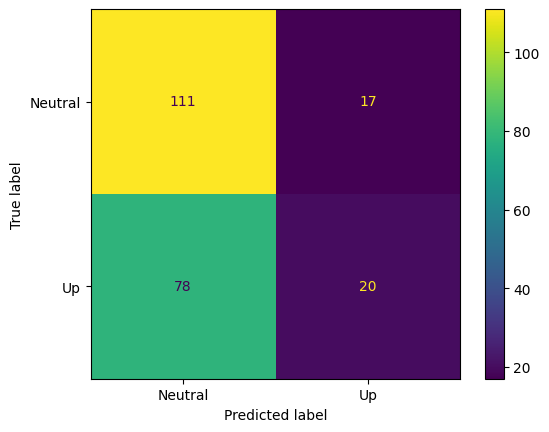

In [14]:
# Creating an empty list to store predictions
PredUp = []

# Looping through the test data (Threshold = 0.5)
for i in range(X_test.shape[0]):
    
    # Appending the prediction
    if Predict(X_test[i], TheEdgeUp, False)[0][0] >= 0.5:
        PredUp.append(1)

    elif Predict(X_test[i], TheEdgeUp, False)[0][0] < 0.5:
        PredUp.append(0)

# Calculating the confusion matrix of the test data
EdgeUpConfusionMatrix = confusion_matrix(Y_test.reshape(Y_test.shape[0]), PredUp, labels=[0,1])

# Displaying the confusion matrix
ConfMatrDisplay = ConfusionMatrixDisplay(EdgeUpConfusionMatrix, display_labels=["Neutral", "Up"])
ConfMatrDisplay.plot()

In [15]:
# (TP + TN) / (TP + TN + FP + FN)
Accuracy(X_test, Y_test, TheEdgeUp)
print()

# TP / (TP + FP)
Precision(X_test, Y_test, TheEdgeUp)
print()

# TP / (TP + FN)
Recall(X_test, Y_test, TheEdgeUp)
print()

# 2 x (Prec x Recall) / (Prec x Recall)
F1Score(X_test, Y_test, TheEdgeUp)
print()

# TN / (TN + FP)
print(f"Specificity: {Specificity(X_test, Y_test, TheEdgeUp)}")
print()

Accuracy:  0.5796460176991151

Precision: 0.5405405405405406

Recall: 0.20408163265306123

F1 Score: 0.2962962962962963

Specificity: 0.8671875



### **_Saving_**

In [21]:
# Extracting the weights and biases for each layer of the up network
Weights, Biases = Extract(TheEdgeUp)

# Saving to a file
Save(Weights, Biases, "C:/Users/redmo/Desktop/The Edge 1.0/Saved Nets/ANNEU_AAPL_1D")

Saved...


### **_Visualising_**

In [ ]:
# Loading data data
data = yf.Ticker("AAPL")
data = data.history(period="3y", interval="1d")
data = data.drop(columns=["Dividends", "Stock Splits"])
data = data.loc["2021-03-29":"2024-03-29"]
data = data.iloc[500:]

# Adding the RSI
data["Rsi"] = (ta.rsi(data["Close"], 21) / 100)

# Adding the ATR
data["Atr"] = ta.atr(data["High"], data["Low"], data["Close"], 5)

# Adding the Returns
data["Returns"] = data["Close"].pct_change()

# Adding the MAs
data["Fast"] = ta.ma("sma", data["Close"], length=14)
data["Slow"] = ta.ma("sma", data["Close"], length=30)

# Adding a binary indicator
data["F>S"] = (data["Fast"] > data["Slow"]).astype(int)

# Creating BBands
bbands = ta.bbands(data["Close"], 21, 1)

# Adding the BBands
data["Upper B"] = bbands["BBU_21_1.0"]
data["Lower B"] = bbands["BBL_21_1.0"]

# nighgh
data["UB Breached"] = (data["Close"] > data["Upper B"]).astype(int)
data["LB Breached"] = (data["Close"] < data["Lower B"]).astype(int)

# Placeholders for the slopes
fastslopes = []
slowslopes = []

# Deriving the MA slope
for i in range(len(data)):
    
    # Making sure indexing stays in bounds
    if i-1 >= 0:

        # Slope Calcualtions, rise / run
        fastslope = (data["Fast"].iloc[i] - data["Fast"].iloc[i-1]) / 2
        fastslopes.append(fastslope)
        slowslope = (data["Slow"].iloc[i] - data["Slow"].iloc[i-1]) / 2
        slowslopes.append(slowslope)

    # Appending for size difference
    else:
        fastslopes.append(np.NaN)
        slowslopes.append(np.NaN)

# Adding the slopes to the df
data["F Slope"] = fastslopes
data["S Slope"] = slowslopes

# Volatility
data["Vol"] = data["Returns"].rolling(21).std()
data.dropna(inplace=True)

# Reshaping
features = np.array(data[["F Slope", "S Slope", "Vol", "UB Breached", "LB Breached", "F>S", "Rsi", "Returns"]]).reshape(data.shape[0], 8, 1)

In [ ]:
# Placeholder list
UpPreds = []

# Iterating through the features
for i in range(len(features)):

    if Predict(features[i], TheEdgeUp, False)[0][0] >= 0.5:
        UpPreds.append(1)

    elif Predict(features[i], TheEdgeUp, False)[0][0] < 0.5:
        UpPreds.append(0)

# Placeholder list
UpPredsCol = []
UpPredsSymbol = []

# Iterating through the predictions
for i in range(len(UpPreds)):

    # Determining if its up
    if UpPreds[i] == 1:

        # Appending appropriate colour/symbol
        UpPredsCol.append("Green")
        UpPredsSymbol.append("triangle-up")

    # Determining if its neutral
    else:

        # Appending appropriate colour/symbol
        UpPredsCol.append("Yellow")
        UpPredsSymbol.append("line-ew-open")

# Creating the figure
fig = go.Figure()

# Creating the candlestick plot
fig.add_trace(go.Candlestick(x=data.index,
                             open=data["Open"],
                             high=data["High"],
                             low=data["Low"],
                             close=data["Close"],
                             name="OHLC"))

# Adding the up predictions
fig.add_trace(go.Scatter(x=data.index,
                         y=data["Close"],
                         mode="markers",
                         marker=dict(color=UpPredsCol, symbol=UpPredsSymbol, size=17, opacity=0.7),
                         name="Up Preds"))

# Updating the layout
fig.update_layout(height=600,
                  width=1200,
                  xaxis_rangeslider_visible=False)

# Displaying the figure
fig.show()